In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/roberta-weights/model.h5
/kaggle/input/bangalore-tweets/finalbangalore-1.csv
/kaggle/input/bangalore-tweets/finalbangalore-2.csv


In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

2022-02-13 14:11:14.010610: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-13 14:11:14.010732: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

2022-02-13 14:11:18.613583: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-13 14:11:18.616537: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-13 14:11:18.616566: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-13 14:11:18.616609: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2ce01dfc602c): /proc/driver/nvidia/version does not exist
2022-02-13 14:11:18.620331: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU  grpc://10.0.0.2:8470
Number of replicas: 8


In [4]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 35
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 2

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [5]:
df1 = pd.read_csv('../input/bangalore-tweets/finalbangalore-1.csv')
df2 = pd.read_csv('../input/bangalore-tweets/finalbangalore-2.csv')
df1 = df1.drop(['Unnamed: 0'],axis=1)
df2 = df2.drop(['Unnamed: 0'],axis=1)
df = pd.concat([df1,df2])
df = df.reset_index(drop = True)
df

,id,date,content
0,1366175800463007745,2021-02-28,sting story sep
1,1366175505980870656,2021-02-28,stretch little bit tehelka nailed real story g...
2,1366174268577308672,2021-02-28,bjp pracharak home minister
3,1366173218273431553,2021-02-28,bjps yardstick congress stop claiming party di...
4,1366171921390297091,2021-02-28,super beautiful boob press
...,...,...,...
673265,1454966105974317059,2021-11-01,anybody deserves bharat ratna india today manm...
673266,1454965776285196291,2021-11-01,janam guru log hai
673267,1454964623472349186,2021-11-01,brother aditya shanmukhappavishwanath film pro...
673268,1454964155455135747,2021-11-01,corruption made india victim climate change ef...


In [6]:
from datetime import datetime

def strtodate(text):
    return datetime.strptime(text, '%Y-%m-%d').date()

df['date']=df['date'].apply(strtodate)

In [7]:
df = df.sort_values(by="date")
df = df.reset_index(drop=True)
df

,id,date,content
0,1345046599878070273,2021-01-01,new year welcome year happy new year
1,1345004866272260099,2021-01-01,borassus flabellifer popularly known ice apple...
2,1345004740984229890,2021-01-01,best loading screen year history game top job
3,1345004627482144768,2021-01-01,confusion react flutter chosen react sure ill ...
4,1345004052170510337,2021-01-01,mane baadighe corona timenalli kellbaardhantha...
...,...,...,...
673265,1476849393240215552,2021-12-31,year wise sector performance
673266,1476849593090404361,2021-12-31,required website working fine thanks also time...
673267,1476849792617566210,2021-12-31,jameel yag vagah govee hithuge adin evves thaa...
673268,1476849970116325381,2021-12-31,lets see easy difficult recognize caricatura c...


In [8]:
X_data = df[['content']].to_numpy().reshape(-1)

In [9]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [10]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [12]:
with strategy.scope():
    model = build_model(2)
    model.summary()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [13]:
model.load_weights('../input/roberta-weights/model.h5')

In [14]:
X_train = roberta_encode(X_data, tokenizer)

In [15]:
predictions = model.predict(X_train)
print(predictions)

[[0.6882854  0.31171456]
 [0.9200594  0.07994069]
 [0.8036502  0.19634975]
 ...
 [0.99031365 0.00968642]
 [0.41054165 0.5894583 ]
 [0.92683655 0.07316343]]


In [16]:
classes = np.argmax(predictions, axis = 1)
print(classes)

[0 0 0 ... 0 1 0]


In [17]:
df['label']=classes
df

,id,date,content,label
0,1345046599878070273,2021-01-01,new year welcome year happy new year,0
1,1345004866272260099,2021-01-01,borassus flabellifer popularly known ice apple...,0
2,1345004740984229890,2021-01-01,best loading screen year history game top job,0
3,1345004627482144768,2021-01-01,confusion react flutter chosen react sure ill ...,0
4,1345004052170510337,2021-01-01,mane baadighe corona timenalli kellbaardhantha...,1
...,...,...,...,...
673265,1476849393240215552,2021-12-31,year wise sector performance,1
673266,1476849593090404361,2021-12-31,required website working fine thanks also time...,1
673267,1476849792617566210,2021-12-31,jameel yag vagah govee hithuge adin evves thaa...,0
673268,1476849970116325381,2021-12-31,lets see easy difficult recognize caricatura c...,1


In [18]:
df.to_csv('Bangalore_updated.csv')

In [19]:
df['label'].value_counts()

1    355305
0    317965
Name: label, dtype: int64

In [24]:
x = df.groupby('date') \
       .agg({'content':'size', 'label':'mean'}) \
       .rename(columns={'content':'count','label':'PCI'}) \
       .reset_index()
print (x)

           date  count       PCI
0    2021-01-01   2079  0.512266
1    2021-01-02   1699  0.519129
2    2021-01-03   1751  0.511708
3    2021-01-04   2254  0.596273
4    2021-01-05   1807  0.494189
..          ...    ...       ...
360  2021-12-27   1648  0.484223
361  2021-12-28   1762  0.458002
362  2021-12-29   1826  0.452355
363  2021-12-30   1845  0.442276
364  2021-12-31   2378  0.386459

[365 rows x 3 columns]


In [27]:
x.to_csv('Bangalore_PCI.csv')

<AxesSubplot:xlabel='date'>

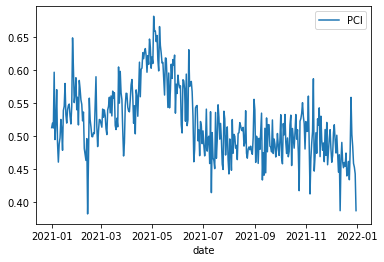

In [25]:
x.plot(x="date", y=["PCI"])